In [1]:
#optimal transport library
#import ot

import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn

#statistics
import scipy

#machine learning library for time series
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import math
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import covariance
import itertools
import copy
import math


import matplotlib.pyplot as plt
import torch
import datetime
from datetime import date
from eod import EodHistoricalData

import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

#import helpers
import ray
import pytz
import time
#misc
%matplotlib inline
plt.style.use('matplotlibrc')



In [2]:
eastern = pytz.timezone('US/Eastern')
api_key = "6149ef1b322b37.04228930"
client = EodHistoricalData(api_key)

In [3]:
components = client.get_fundamental_equity('GSPC.INDX')['Components']
tickers = [components[str(i)]['Code'] for i in range(len(components))]

'''
import os
opens = {}
files = os.listdir('DailyData')
for file in tqdm(files):
    df = pd.read_pickle('DailyData/'+file)
    #df.index = pd.to_datetime(df['date'])
    df.index = pd.to_datetime(df.Date.str[:-15])
    opens[file[:-3]] = df
'''

# save dictionary as pickle file
import pickle
def savePickle(dictionary, filename):
    pickle_out = open(filename+'.pickle', 'wb')
    pickle.dump(dictionary, pickle_out)
    pickle_out.close()

#savePickle(splits, 'splits')

# create new dictionary from pickle file
pickle_in = open('pricesNotAdj.pickle', 'rb')
prices = pickle.load(pickle_in)
for tick in prices.keys(): #prices.keys()
    prices[tick].index = pd.to_datetime(prices[tick].index)
    
'''
tickers = prices.keys()
for tick in tickers:
    for item in ['open', 'high', 'low']:
        price = copy.deepcopy(prices[tick])
        result = prices[tick].close / prices[tick].adjusted_close
        price[item] /= result
        prices[tick] = price
            #data['volume'][data['volume'].index < sp['date']] *= int(sp['split'][0])
'''

pricesDF = pd.concat(prices, axis=1)
pricesDF = pricesDF[pricesDF.index > '2003-12-01'].dropna(axis=1)
adjclose = pricesDF.loc[:, (tickers, ['adjusted_close'])]
adjopen = pricesDF.loc[:, (tickers, ['open'])]
volumes = pricesDF.loc[:, (tickers, ['volume'])]
adjclose.columns = adjclose.columns.droplevel(1)
adjopen.columns = adjopen.columns.droplevel(1)
volumes.columns = volumes.columns.droplevel(1)


In [4]:
def getMinArr(file='/Users/kevtan/Library/CloudStorage/OneDrive-Personal/Documents/UMich/Trading/genPerms/jumpdiff/minutesDict.pickle.pickle', 
              mind=False):
    pickle_in = open(file, 'rb')
    minutes = pickle.load(pickle_in)
    mindexes = [i.index for i in minutes.values()]
    mindex = mindexes[0]
    for i in range(1, len(mindexes)):
        mindex = mindex.union(mindexes[i])
    mindex = mindex.intersection(adjopen.index.date)
    for k in minutes.keys():
        minutes[k] = minutes[k].reindex(mindex)
    minArr = np.array([minutes[k].values for k in minutes.keys()])
    if mind:
        return minArr, pd.to_datetime(mindex)
    else:
        return minArr
minArr, mindex = getMinArr(mind=True)

#adjustments
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    return arr[np.arange(idx.shape[0])[:,None], idx]

In [5]:
minArr, mindex = getMinArr(mind=True)
minFill = np.array([ffill(minArr[i,:,:]) for i in range(len(minArr))])
minclose = pd.DataFrame(minFill[:, :, -1].T, index = mindex, columns = adjclose.columns)
adjustments = minclose / adjclose.reindex(mindex)

minArr = minArr / adjustments.values.T[:,:,None]
minHigh = getMinArr('/Users/kevtan/Library/CloudStorage/OneDrive-Personal/Documents/UMich/Trading/genPerms/jumpdiff/minutesHigh.pickle.pickle') / adjustments.values.T[:,:,None]
minLow = getMinArr('/Users/kevtan/Library/CloudStorage/OneDrive-Personal/Documents/UMich/Trading/genPerms/jumpdiff/minutesLow.pickle.pickle') / adjustments.values.T[:,:,None]
minWap = (minArr + minHigh + minLow)/3

In [6]:
minWapFill = np.array([ffill(minWap[i,:,:]) for i in range(len(minWap))])
minCloseFill = np.array([ffill(minArr[i,:,:]) for i in range(len(minArr))])
tradeclose = pd.DataFrame(np.nanmean(minWapFill[:,:, -10:], axis=2).T, index = mindex, columns = adjclose.columns)
priceclose = pd.DataFrame(minCloseFill[:,:, -11].T, index = mindex, columns = adjclose.columns)

In [7]:
tradeclose = tradeclose[tradeclose.columns[(tradeclose.isna().sum(axis=0) < 20)]].iloc[:-2,:].dropna(axis=0)
mindex = tradeclose.index
mincol = tradeclose.columns

In [8]:
monthrets = adjclose[np.array([i.day for i in adjclose.index.date]) == 1].pct_change(1).dropna()
signalrets = ((priceclose - adjclose.shift(1)) / adjclose.shift(1)).loc[mindex, mincol]
traderets = tradeclose.pct_change(1)
returns = adjclose.pct_change(1).dropna().reindex(signalrets.index.intersection(traderets.index))[mincol]
traderets = traderets.reindex(returns.index).dropna()
signalrets = signalrets.reindex(returns.index)

In [349]:
#minWapFill = np.array([ffill(minWap[i,:,:]) for i in range(len(minWap))])
#minCloseFill = np.array([ffill(minArr[i,:,:]) for i in range(len(minArr))])
#tradeclose = pd.DataFrame(minCloseFill[:,:, -10:].mean(axis=2).T, index = adjclose.index, columns = adjclose.columns)
#priceclose = pd.DataFrame(minCloseFill[:,:, -11].T, index = adjclose.index, columns = adjclose.columns)

In [14]:
#monthrets = adjclose[np.array([i.day for i in adjclose.index.date]) == 1].pct_change(1).dropna()
#signalrets = ((priceclose - adjclose.shift(1)) / adjclose.shift(1)).dropna()
#traderets = tradeclose.pct_change(1).dropna()
#returns = adjclose.pct_change(1).dropna().reindex(signalrets.index.intersection(traderets.index))
#traderets = traderets.reindex(returns.index)
#signalrets = signalrets.reindex(returns.index)

# Residual Creation

Here, we use five-factor PCA residuals for now, on monthly close returns. This is suboptimal, compared to the IPCA of Kelly et. al. and as such I recommend getting and cleaning CSRP/Compustat or even Yahoo Finance data as soon as possible to effectively replicate the analysis in the paper. 

Text(0.5, 1.0, 'PCA on Returns Matrix')

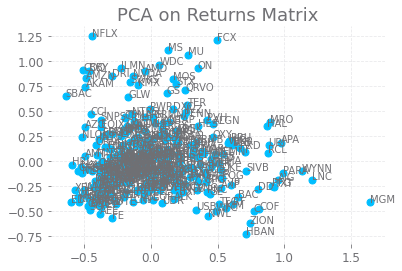

In [9]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=5, whiten=False).fit_transform(monthrets.iloc[:1000,:].dropna().T)
#pca = KernelPCA(n_components=2, kernel='rbf').fit_transform(returns.loc[dates_train].T)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1])
for i, txt in enumerate(adjclose.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))
ax.set_title("PCA on Returns Matrix")

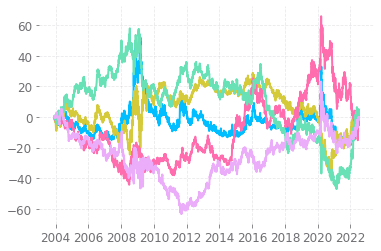

In [10]:
pcaLong = pd.DataFrame(PCA(n_components=5, whiten=True).fit_transform(returns), index = returns.index)
plt.plot(np.cumsum(pcaLong))
#plt.plot(pcaLong/10)

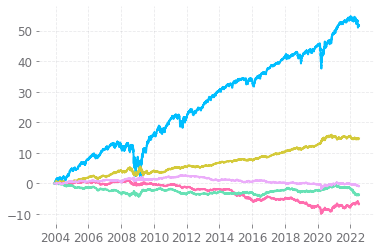

In [11]:
plt.plot(-np.cumsum(returns @ (PCA(n_components=5, whiten=True).fit(returns).components_).T))

## PCA Factor Computation

This is the first bit of the meat involved in the residual computation. Here, we have a multiprocessed piece of code that computes factor returns for the past `olslookback` days, with the `n_factors`-PCA fit on the past `lookback` days. Expect `factors` to be a `pd.Series` where each date contains a `pd.DataFrame` of the relevant factor returns, ready for residual computation with OLS.

In [12]:
n_factors = 5
lookback = 252
olslookback = 60
oos = False

def pca_fit(date, returns=returns, signalrets=signalrets, n_components=n_factors, 
            lookback=lookback, olslookback=olslookback, oos=True):
    retdate = returns[returns.index < date] if oos else returns[returns.index <= date]
    if not oos:
        retdate.loc[date] = signalrets.loc[date]
    
    X = retdate.iloc[-lookback:, :].values
    X_index = retdate.iloc[-lookback:, :].index
    X_mean = np.mean(X, axis=0, keepdims=True)
    X_vol = np.sqrt(np.mean((X-X_mean)**2,axis=0,keepdims=True))
    X_norm = (X - X_mean) / X_vol
    Corr = X_norm.T @ X_norm
    #Corr = X.T @ X
    eigVal, eigVec = np.linalg.eigh(Corr)
    
    wt = (1/X_vol)
    components = eigVec[:, -n_components:].real 
    components = components * wt.T
    components /= np.sum(np.abs(components),0)
    
    X_reg = X[-olslookback:,:]
    
    factors = np.dot(X_reg, components) 
    factorsDF = pd.DataFrame(factors, index = X_index[-olslookback:], 
                        columns = [i for i in range(n_components)])
    
    dayfactors = np.dot(np.array([signalrets.loc[date]]), components).squeeze()
    dayfactorSeries = pd.Series(dayfactors, index = [i for i in range(n_components)])
    
    betas = np.linalg.pinv(factors.T @ factors) @ factors.T @ X_reg
    residuals = signalrets.loc[date] - np.dot(dayfactors, betas)
    #print(residuals)
    #print(residuals)
    #print(residuals / (1+np.sum(np.abs(betas))))
    #residuals = residuals / (1+np.sum(np.abs(betas)))
    
    return factorsDF, dayfactorSeries, residuals, components, betas, wt

In [13]:
results = []
for date in tqdm(returns.index[lookback:]):
    results.append(pca_fit(date, oos=oos))

100%|██████████████████████████████████████| 4402/4402 [00:36<00:00, 119.55it/s]


In [14]:
factors = [res[0] for res in results]
dayFactors = [res[1] for res in results]
dayFactors = pd.DataFrame(dayFactors, index = returns.index[lookback:])
residuals = pd.DataFrame([res[2] for res in results], index = returns.index[lookback:])
eigens = np.array([res[3] for res in results])
betas = np.array([res[4] for res in results])
vols = np.array([res[5] for res in results])
vols = vols.reshape(vols.shape[0], vols.shape[2])

<AxesSubplot:xlabel='date'>

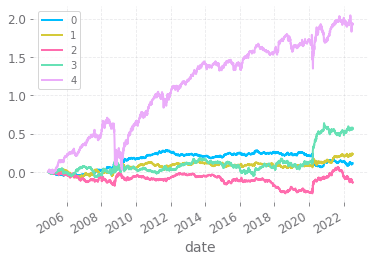

In [15]:
(dayFactors).cumsum().plot()

In [16]:
import multiprocessing
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

def getHedgeWeights(stock, returns=returns, betas=betas, eigens = eigens, 
                    lookback=lookback, olslookback=olslookback):
    hedge = pd.DataFrame(0, index=returns[lookback:].index, columns=returns.columns)
    j = np.argmax(returns.columns == stock)
    for i,date in enumerate(hedge.index):
        hedgeWeight = -((betas[i, :, j][:, None] * eigens[i].T).sum(0))
        normfactor = (1+np.sum(np.abs(hedgeWeight)))
        hedgeWeight = hedgeWeight / normfactor
        hedge.loc[date] += hedgeWeight
        hedge.loc[date, stock] += 1 / normfactor
    return hedge

with ProcessPoolExecutor(max_workers=10, mp_context=multiprocessing.get_context('fork')) as executor:
    future = executor.map(getHedgeWeights, returns.columns)
    executor.shutdown()
hedgeWeights = list(future)

In [17]:
from functools import reduce
hedge = reduce(lambda x, y: x.add(y), hedgeWeights) #shape stockHedged, dates, hedgesForStock
hedgeArr = np.array(hedgeWeights).transpose(1,0,2) #shape dates, stockHedged, hedgesForStock
#hedgenorm = hedge / returns.shape[1]

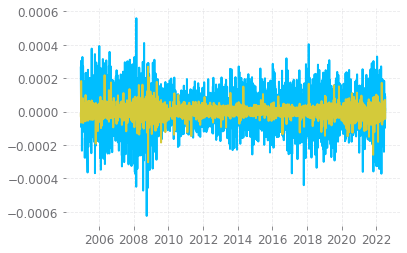

In [18]:
plt.plot((hedge*traderets).mean(1))
plt.plot(residuals['FISV']/311)

<AxesSubplot:xlabel='date'>

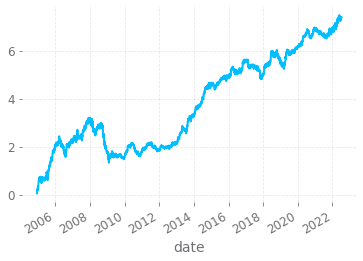

In [19]:
((hedge * traderets).sum(1)[lookback:]).cumsum().plot()

<AxesSubplot:xlabel='date'>

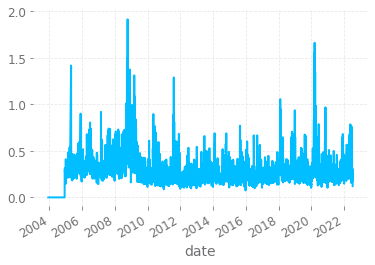

In [21]:
(hedge*traderets).abs().sum(1).plot()

<AxesSubplot:xlabel='date'>

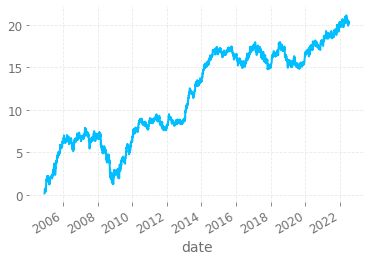

In [22]:
(residuals.sum(1)).cumsum().plot()

## Avellenada and Lee with OOS Residuals

We obtain factor loadings of each stock via regressing each stock's past `olslookback`-day returns on the factors themselves. Residuals are computed 'out-of-sample' as such: the residual at time $t$ is given by subtracting $\text{Factors}_{t} \beta_{t-1}$ from $r_{t}$, where $r_{t} = \frac{p_t - p_{t-1}}{p_{t-1}}$. 

As mentioned earlier, $\text{Factors}_t$ is generated by fitting on the past $t-lookback$ to $t-1$ days, and transforming either the signal or VWAP returns at time $t$.

We use the 3:50pm price as $p_t$ to compute returns, stored in `signalrets`. Realistically, we can only compute signals from that price. Trades are executed with the 3:50pm to 4:00pm VWAP, stored in `traderets`.

Note that as we compute values based on $r_t$, we will have to shift `returns` by 1 when taking the product of it with `weights` (think $w_t \cdot r_{t+1}$) to get a backtest result. This will not be necessary if using `bt`, however.

This is a very different approach than the original paper. Here, we look at the traded residuals at time 1,...,t (at every timestep), instead of using the residuals generated by the factor model estimated at time t for time 1,...,t (as Avellenada and Lee do). The latter generally behaves better and is more predictable, as we're using time t information to estimate residuals for time 1,...,t. 

## The Dumbest Possible Strategy

Let's see what happens when we get as lazy as possible. We're going to go in on the open threshold of an s-score of +-1.25, and exit the day after. Results are not bad!

In [63]:
np.sum(np.abs(np.nansum(hedgeArr[-1] * sigArr[-1][:,None], 0) - (sigArr[-1] @ hedgeArr[-1])) < 1e-10)

303

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-12-10  2004-12-10
End Period                 2022-07-08  2022-07-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          234.42%     359.72%
CAGR﹪                     7.11%       9.06%

Sharpe                     1.84        0.55
Prob. Sharpe Ratio         100.0%      98.85%
Smart Sharpe               1.64        0.49
Sortino                    2.95        0.76
Smart Sortino              2.63        0.68
Sortino/√2                 2.09        0.54
Smart Sortino/√2           1.86        0.48
Omega                      1.38        1.38

Max Drawdown               -9.03%      -55.19%
Longest DD Days            408         1772
Volatility (ann.)          3.79%       19.48%
R^2                        0.01        0.01
Information Ratio          -0.01       -0.01
Calmar                     0.79     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-01-14,2009-03-04,2009-04-27,103,-9.025292,-8.878698
2,2021-05-26,2021-10-22,2022-07-08,408,-4.582834,-4.424743
3,2020-02-28,2020-03-17,2020-03-25,26,-4.075285,-3.798890
4,2008-05-28,2008-07-14,2008-08-06,70,-3.460192,-3.133596
5,2008-10-21,2008-10-27,2008-10-31,10,-2.996413,-2.230281


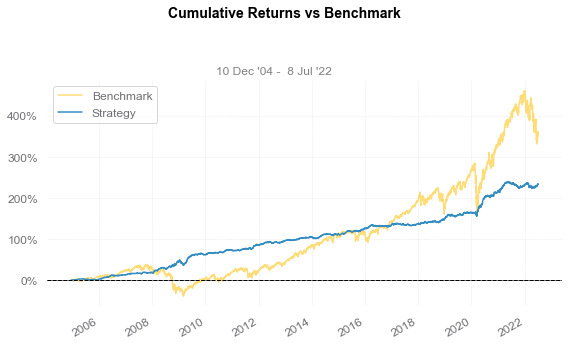

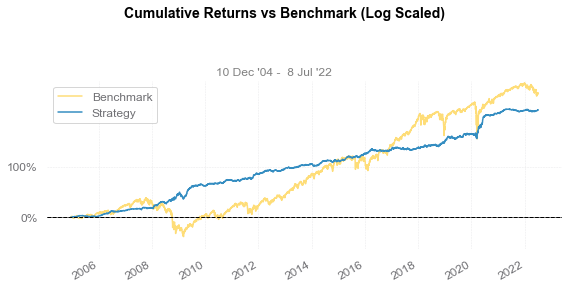

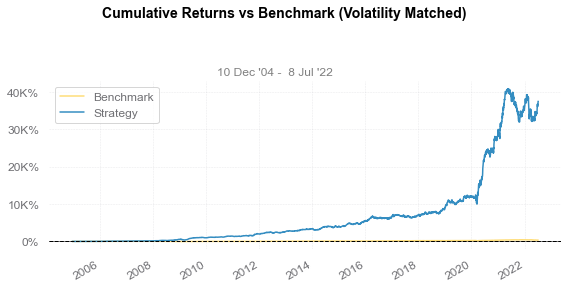

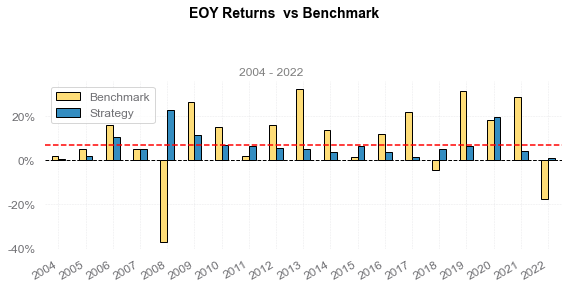

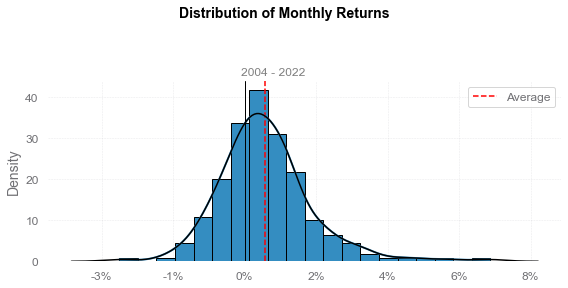

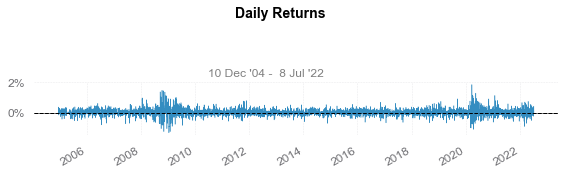

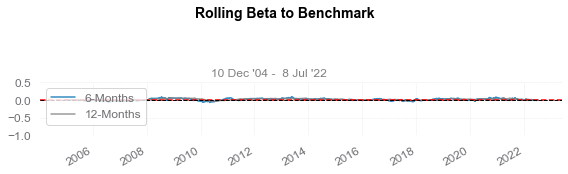

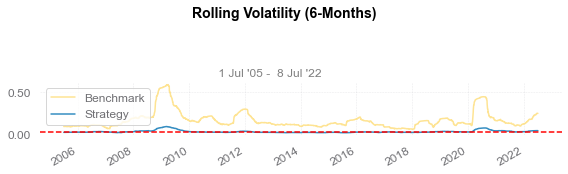

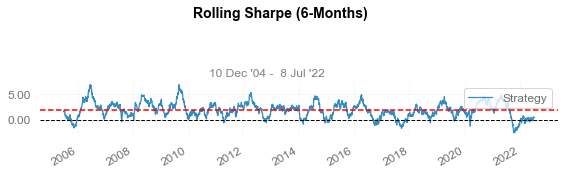

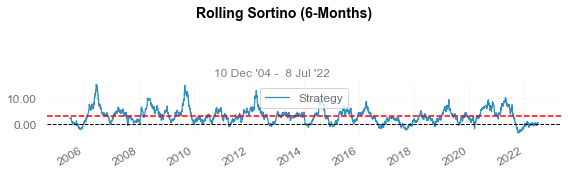

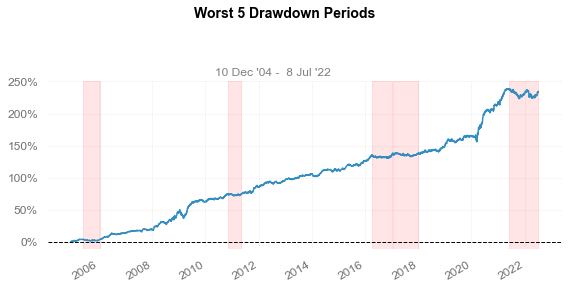

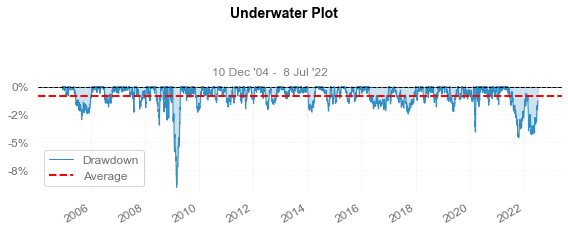

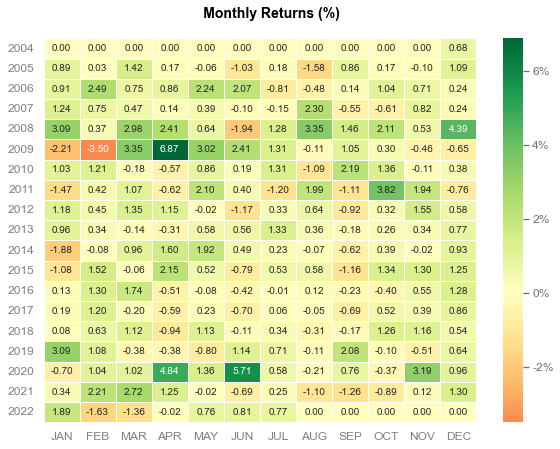

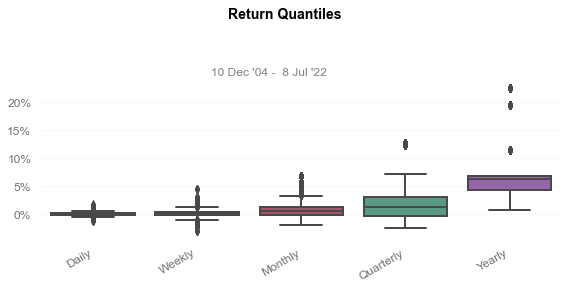

In [61]:
import quantstats as qs
sumresid = residuals.cumsum() #use residuals as signals, but not as tradable instruments
sscores = ((sumresid - sumresid.ewm(20).mean())/sumresid.ewm(20).std())
thresh = 1.25
signals = -(sscores > thresh).astype(int) + (sscores < -thresh).astype(int)
sigArr = signals.div(signals.abs().sum(1), 0).to_numpy()
weightssc = np.array([sigArr[i] @ hedgeArr[i] for i in range(len(signals))]) 
#we take the transpose (multiply on the right) as we want the linear combination of the rows of hedgeArr
weightssc /= np.abs(weightssc).sum(1)[:, None]
qs.reports.full((weightssc * 
                 traderets.reindex(signals.index).shift(-1)).sum(1), 'SPY')
plt.style.use('matplotlibrc')

In [64]:
import statsmodels.api as sm
def arsignal(stock, window=60):
    slopes = []
    intercepts = []
    rs = []
    stds = []
    xs = []
    #for i in range(window+1, len(stock)):
    #    windex = stock[i-window-1:i]
    for i, date in enumerate(stock.index[window+1:]):
        windex = (stock[stock.index <= date][-(window+1):])
        x = windex[:-1]
        y = windex[1:]
        #plt.plot(x)
        #plt.plot(y)
        #break
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y) #shift signals by 1 later
        slopes.append(slope)
        intercepts.append(intercept)
        rs.append(r_value**2)
        stds.append(np.std(y - (intercept + slope*x)))
        xs.append(y[-1])
    return np.array(slopes), np.array(intercepts), np.array(rs), np.array(stds), np.array(xs)
slopes, intercepts, rs, stds, xs = arsignal(residuals['AAPL'])

with ProcessPoolExecutor(max_workers=10, mp_context=multiprocessing.get_context('fork')) as executor:
    arsignals = list(tqdm(executor.map(arsignal, [residuals[stock] for stock in returns.columns])))
    executor.shutdown()

303it [01:17,  3.90it/s]


In [65]:
window = 60
arindex = residuals.index[window+1:]
slopes = pd.DataFrame(np.array([signal[0] for signal in arsignals]).T, 
                      index=arindex, columns=returns.columns)
intercepts = pd.DataFrame(np.array([signal[1] for signal in arsignals]).T, 
                      index=arindex, columns=returns.columns)
rs = pd.DataFrame(np.array([signal[2] for signal in arsignals]).T, 
                      index=arindex, columns=returns.columns)
stds = pd.DataFrame(np.array([signal[3] for signal in arsignals]).T, 
                      index=arindex, columns=returns.columns)
xs = pd.DataFrame(np.array([signal[4] for signal in arsignals]).T, 
                      index=arindex, columns=returns.columns)

<AxesSubplot:xlabel='date'>

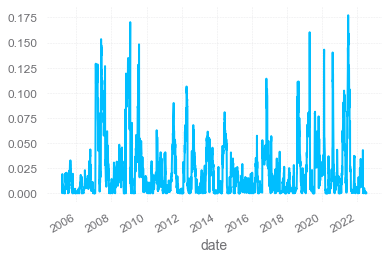

In [26]:
rs.FISV.plot()

In [66]:
def getSignals(sscoreDF, enthresh=1.25, exthresh=0.5):
    sscoresArr = sscoreDF.to_numpy()
    signalsar = np.zeros((len(sscoreDF.index), len(sscoreDF.columns)))
    for i in range(1, len(signalsar)):
        for j in range(signalsar.shape[1]):
            if signalsar[i-1,j] == 1 and sscoresArr[i,j] > -exthresh: #dont sell to close
                signalsar[i,j] == 1
            if signalsar[i-1,j] == -1 and sscoresArr[i,j] < exthresh: #dont buy to close
                signalsar[i,j] = -1
            if sscoresArr[i,j] > enthresh: #sell to open
                signalsar[i,j] = -1
            if sscoresArr[i,j] < -enthresh: #buy to open
                signalsar[i,j] = 1
    return pd.DataFrame(signalsar, sscoreDF.index, sscoreDF.columns)

In [29]:
(4*weightsar * traderets.reindex(signalsar.index).shift(-1)).sum(1).to_csv('pcaArbRets.csv')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2005-03-10  2005-03-10
End Period                 2022-07-08  2022-07-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          2,152.70%   350.35%
CAGR﹪                     19.68%      9.07%

Sharpe                     2.03        0.54
Prob. Sharpe Ratio         100.0%      98.78%
Smart Sharpe               1.88        0.5
Sortino                    3.22        0.76
Smart Sortino              2.98        0.71
Sortino/√2                 2.27        0.54
Smart Sortino/√2           2.11        0.5
Omega                      1.44        1.44

Max Drawdown               -15.51%     -55.19%
Longest DD Days            435         1772
Volatility (ann.)          9.13%       19.58%
R^2                        0.01        0.01
Information Ratio          0.02        0.02
Calmar                     1.27        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-02,2020-03-18,2020-05-22,141,-15.508151,-15.486535
2,2022-02-14,2022-06-16,2022-07-08,144,-13.404159,-13.117303
3,2009-12-01,2010-01-20,2010-05-28,178,-12.400136,-11.424577
4,2009-01-02,2009-03-18,2009-06-26,175,-10.600018,-9.674509
5,2013-02-12,2013-05-15,2014-04-23,435,-10.185871,-9.561809


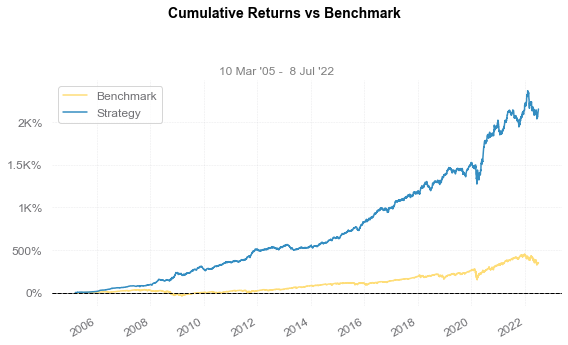

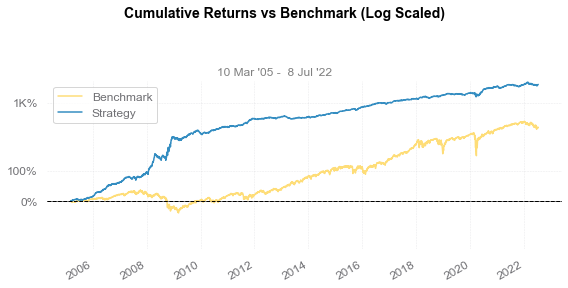

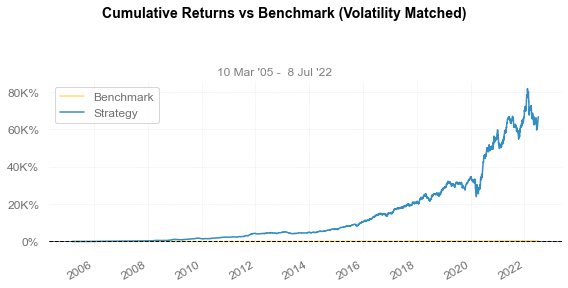

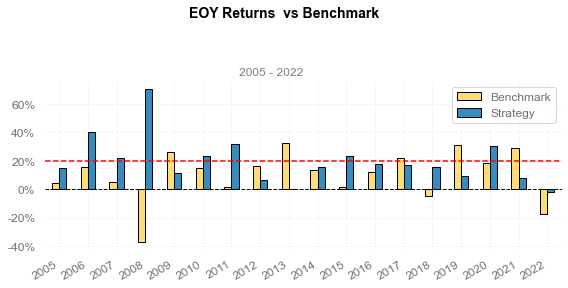

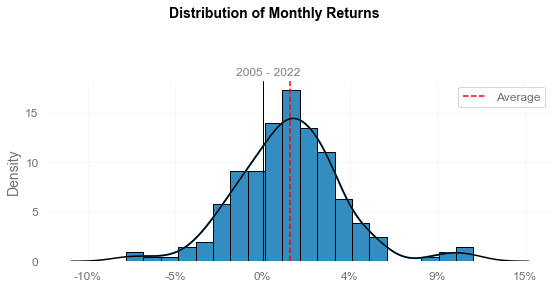

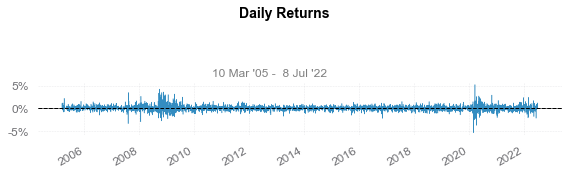

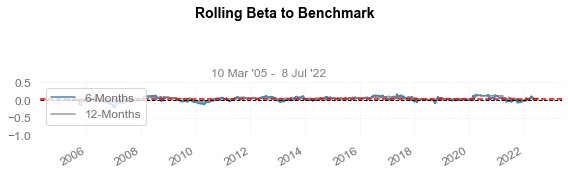

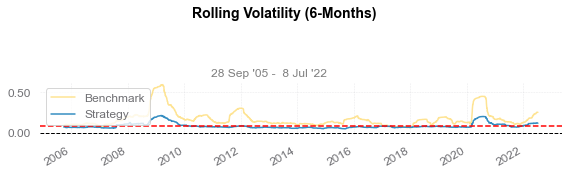

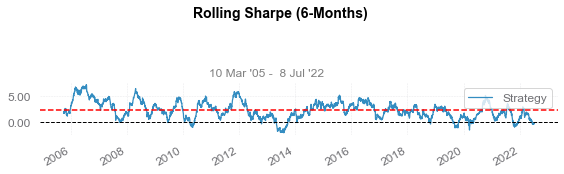

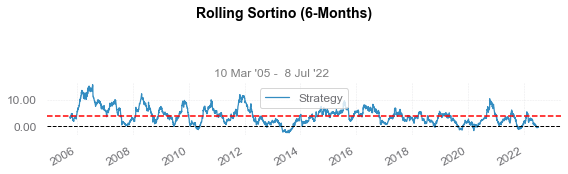

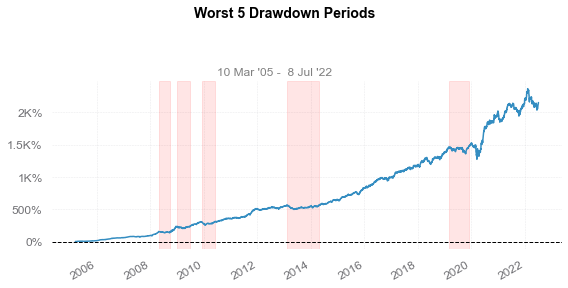

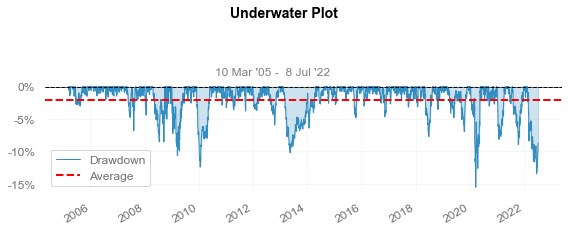

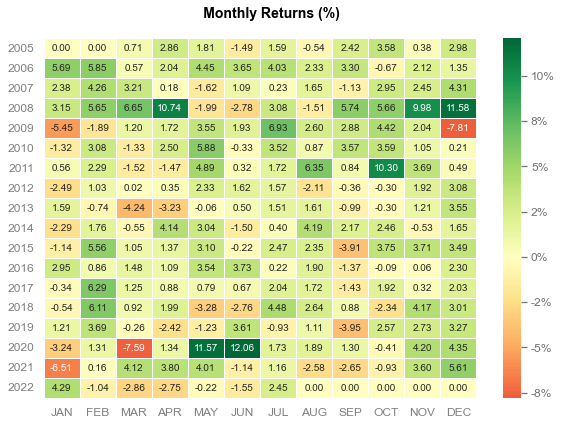

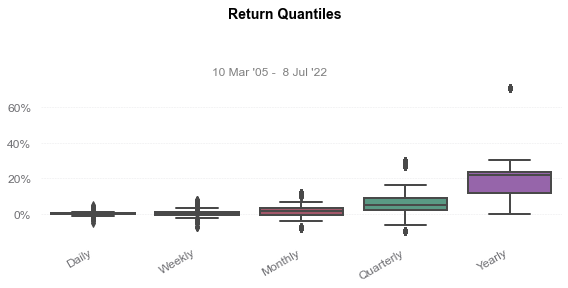

In [67]:
means = (-intercepts*np.sqrt(1-slopes**2))/((1-slopes)*stds)
demeans = np.sqrt((1-slopes**2) / (stds**2)).mul(intercepts.mean(1) / (1-slopes.mean(1)), 0)
sscoresar = xs*np.sqrt((1-slopes**2) / (stds**2)) + means + demeans # xs*np.sqrt((1-slopes**2) / (stds**2)) + 
sscoresar *= slopes < 0.95
sscoresArr = sscoresar.to_numpy()
signalsar = np.zeros((len(sscoresar.index), len(sscoresar.columns)))
enthresh = 0.5
exthresh = 0.2
signalsar = getSignals(sscoresar, 0.5, 0.2)
signalsar = pd.DataFrame(signalsar, sscoresar.index, sscoresar.columns)
signalsar = signalsar.div(signalsar.abs().sum(1),0)
signalsArr = signalsar.to_numpy()
weightsar = np.array([signalsArr[i] @ hedgeArr[i+window+1] for i in range(len(signalsar.index))])
weightsar /= np.abs(weightsar).sum(1)[:, None]
qs.reports.full((4*weightsar *
                 traderets.reindex(signalsar.index).shift(-1)).sum(1), 'SPY')
plt.style.use('matplotlibrc')

## Avellenada and Lee with In-Sample Residuals

Another thing they do that the OOS residual example didn't: They fit OLS with an intercept.

In [105]:
n_factors = 5
lookback = 252
olslookback = 60

def pca_t(date, returns=returns, signalrets=signalrets, n_components=n_factors, 
            lookback=lookback, olslookback=olslookback):
    retdate = returns[returns.index <= date]
    retdate.loc[date] = signalrets.loc[date]
    
    X = retdate.iloc[-lookback:, :].values
    X_index = retdate.iloc[-lookback:, :].index
    X_mean = np.mean(X, axis=0, keepdims=True)
    X_vol = np.sqrt(np.mean((X-X_mean)**2,axis=0,keepdims=True))
    X_norm = (X - X_mean) / X_vol
    Corr = X_norm.T @ X_norm
    #Corr = X.T @ X
    eigVal, eigVec = np.linalg.eigh(Corr)
    
    wt = (1/X_vol)
    components = eigVec[:, -n_components:].real 
    components = components * wt.T
    components /= np.sum(np.abs(components),0)
    
    X_reg = X[-olslookback:,:]
    
    factors = np.dot(X_reg, components) 
    factorsDF = pd.DataFrame(factors, index = X_index[-olslookback:], 
                        columns = [i for i in range(n_components)])
    
    #betas = np.linalg.pinv(factors.T @ factors) @ factors.T @ X_reg
    #residuals = X_reg - factors @ betas
    regr = sklearn.linear_model.LinearRegression(fit_intercept=True,n_jobs=10).fit(factors,X_reg)
    betas = regr.coef_.T
    residuals = X_reg - regr.predict(factors)
    
    return factorsDF, residuals, components, betas, wt

In [106]:
weights = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)
sscoreDF = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)
rsquareDF = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)
slopeDF = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)
interceptDF = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)
stdDF = pd.DataFrame(0, index=returns.index[lookback:], columns=returns.columns)

for i, date in tqdm(enumerate(returns.index[lookback+1:])):
    factorsDF, residuals, components, betas, wt = pca_t(date)
    
    for j, tick in enumerate(returns.columns):
        windex = np.cumsum(residuals[:,j])
        x = windex[:-1]
        y = windex[1:]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y) #shift signals by 1 later
        std = np.std(y - (intercept + slope*x))
        
        slopeDF.loc[date, tick] = slope
        interceptDF.loc[date, tick] = intercept
        rsquareDF.loc[date, tick] = r_value**2
        stdDF.loc[date, tick] = std
        
    intercepts = interceptDF.loc[date]
    slopes = slopeDF.loc[date]
    stds = stdDF.loc[date]
    mean = (-intercepts*np.sqrt(1-slopes**2))/((1-slopes)*stds)
    demean = np.sqrt((1-slopes**2) / (stds**2)).mul(intercepts.mean() / (1-slopes.mean()), 0)
    sscoreDF.loc[date] = mean + demean
    

4399it [04:52, 15.04it/s]


In [105]:
import pickle
with open('examplePickle', 'ab') as file:
    pickle.dump([sscoreDF, rsquareDF, slopeDF, interceptDF, stdDF], file)

<AxesSubplot:>

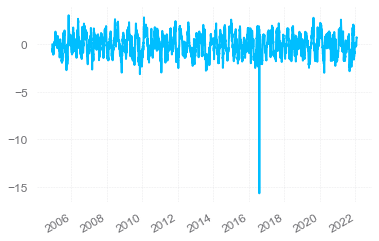

In [106]:
sscoreDF.GPS.plot()

In [107]:
rsquareDF.ge(rsquareDF.quantile(0.4), 1)

,GPS,FISV,CSX,ADP,ANSS,AFL,SO,REG,LMT,EIX,...,MCHP,TYL,BF-B,MAA,BRK-B,HD,EXC,LH,MTD,SLB
2004-12-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-12-07,True,False,False,False,False,True,True,False,True,True,...,True,True,True,False,False,False,True,True,True,False
2004-12-08,True,False,False,False,False,True,True,False,True,True,...,True,True,True,True,False,False,True,True,True,False
2004-12-09,True,False,False,False,False,True,True,True,True,True,...,True,True,True,False,False,False,False,True,True,False
2004-12-10,True,False,False,False,False,True,True,True,True,True,...,True,True,True,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,True,True,True,False,False,False,False,False,True,True,...,False,True,True,True,True,True,True,False,False,True
2022-01-21,True,True,True,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,False,False,True
2022-01-24,True,False,True,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,False,False,True
2022-01-25,True,False,True,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,False,False,True


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-12-06  2004-12-06
End Period                 2022-01-26  2022-01-26
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          2,254.40%   409.33%
CAGR﹪                     20.22%      9.96%

Sharpe                     1.48        0.59
Prob. Sharpe Ratio         100.0%      99.26%
Smart Sharpe               1.31        0.53
Sortino                    2.37        0.83
Smart Sortino              2.1         0.74
Sortino/√2                 1.68        0.59
Smart Sortino/√2           1.49        0.52
Omega                      1.31        1.31

Max Drawdown               -23.0%      -55.19%
Longest DD Days            482         1772
Volatility (ann.)          13.11%      19.24%
R^2                        0.01        0.01
Information Ratio          0.02        0.02
Calmar                     0.88      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-11-05,2020-03-17,2020-03-25,141,-22.998056,-22.946570
2,2009-01-13,2009-03-04,2009-05-20,127,-15.771764,-15.301545
3,2013-12-13,2014-03-27,2015-04-09,482,-13.431830,-12.833462
4,2021-04-08,2021-10-15,2022-01-26,293,-13.067563,-12.576030
5,2009-08-20,2010-01-06,2010-05-11,264,-12.582680,-11.957867


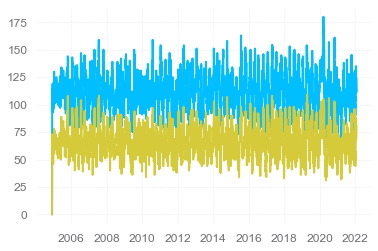

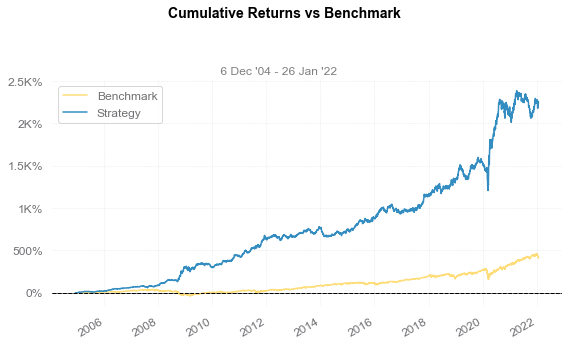

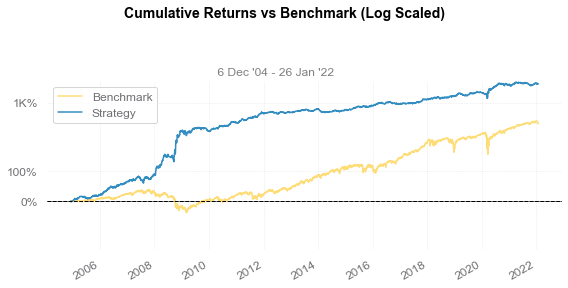

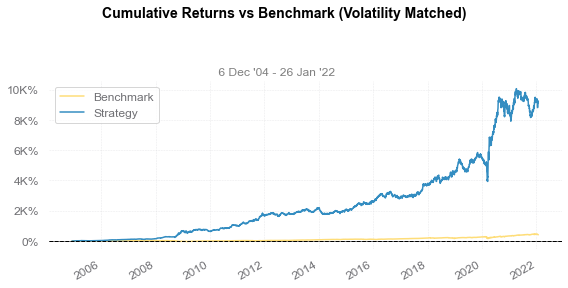

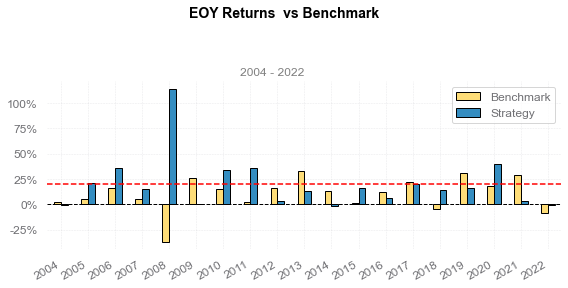

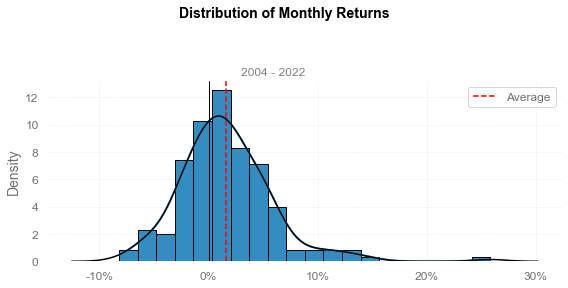

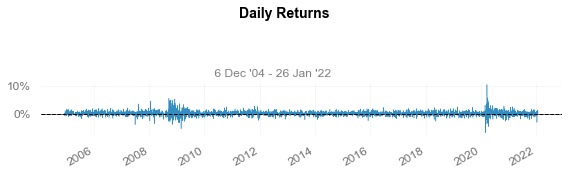

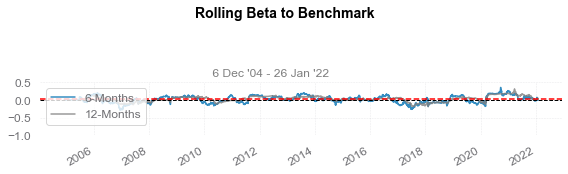

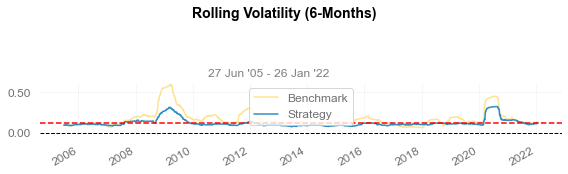

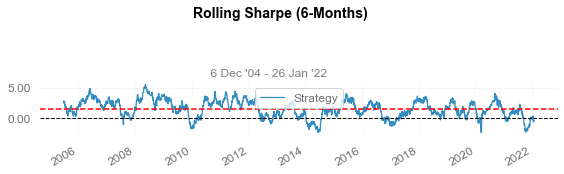

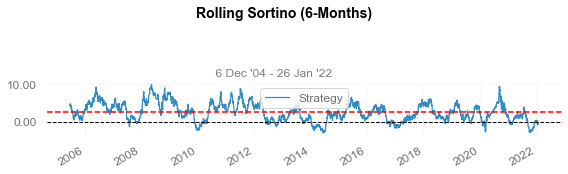

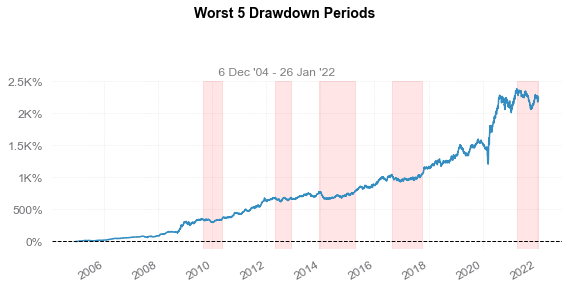

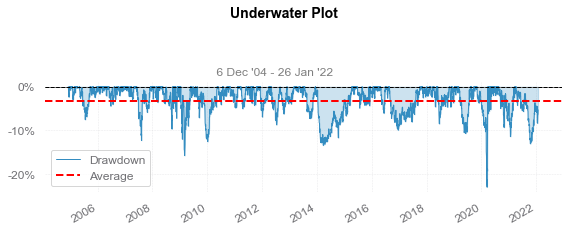

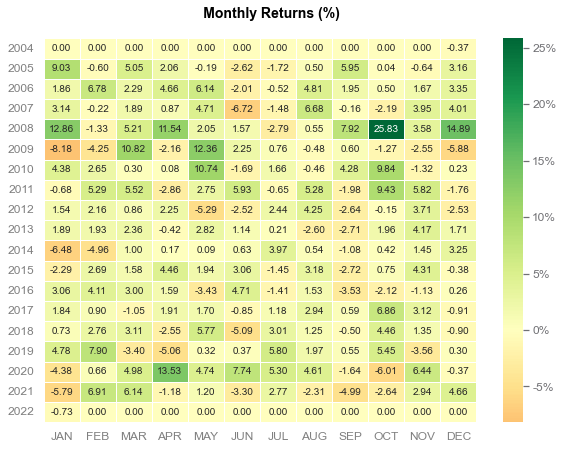

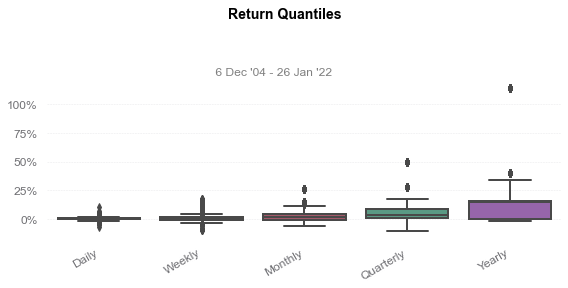

In [110]:
signals = getSignals(sscoreDF, 1.25, 0.5)
halflifes = -np.log(slopeDF) * 252
signals *= slopeDF < 0.95
#signals *= halflifes.le(halflifes.T.quantile(0.8), 0)
#signals *= rsquareDF.ge(rsquareDF.T.quantile(0.2), 0)
#signals *= halflifes < 90
signals *= rsquareDF > 0.4
plt.plot(getSignals(sscoreDF, 1, 0.4).abs().sum(1))
plt.plot(signals.abs().sum(1))

signals = signals.div(signals.abs().sum(1),0)
weights = np.array([signals.to_numpy()[i] @ hedgeArr[i] for i in range(len(signals.index))])
weights /= np.abs(weights).sum(1)[:, None]
qs.reports.full((4*weights * 
                 traderets.reindex(signals.index).shift(-1)).sum(1), 'SPY')
plt.style.use('matplotlibrc')

<AxesSubplot:>

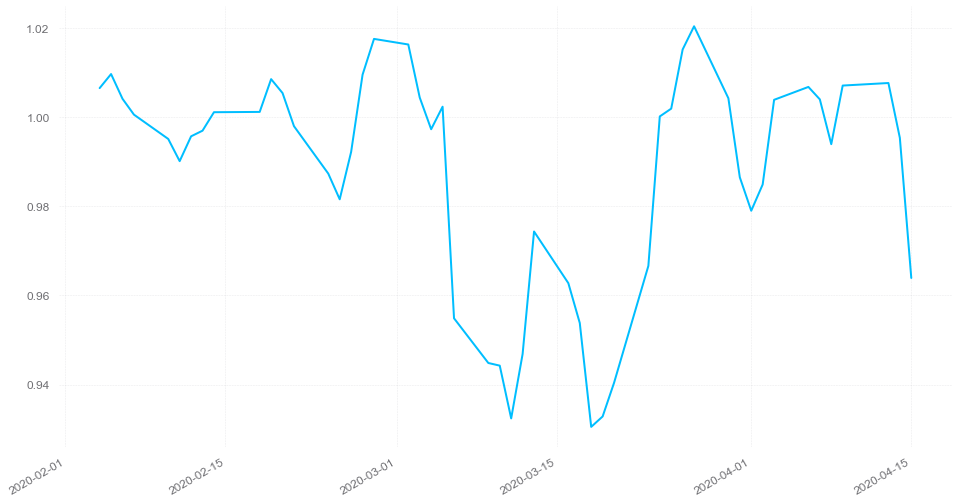

In [122]:
np.cumprod(1+(4*weightsar *
                 traderets.reindex(signalsar.index).shift(-1)).sum(1)[-500:-450]).plot(figsize=(16,9))